# FIT5196 Assessment 3

###  Group 103:

##### Student Name: Alan Gewerc
##### Student ID: 29961246
##### Student Name: Cristiana Garcia Gewerc
##### Student ID: 30088887


Date: 07/10/2019

Environment: Python 3.7.1 and Jupyter Notebook 5.7.4 (64-bit)

Libraries used:
* pandas 0.23.4 (for data frames, included in Anaconda Python 3.7.1) 
* re 2.2.1 (for regular expressions, included in Anaconda Python 3.7.1) 
* matplotlib.pyplot 3.1.0 (for data visualization, included in Anaconda Python 3.7.1)
* numpy 1.15.4 (for array operations, included in Anaconda Python 3.7.1)
* numpy.linalg (for solving system of linear equations)
* itertools (for permutations and chain)
* networkx 2.3 (for Dijkstra algorithm, included in Anaconda Python 3.7.1)
* sklearn.linear_model 0.20.1 (for linear regression)


# 1. Introduction

This assignment comprises the execution of different data cleasing and exploration tasks applied to Food Delivery data from a restaurant in Melbourne, in CSV format. There are a total of 1500 menu orders in three files of 210 KB: `Group103_dirty_data`, `Group103_missing_data`, `Group103_outlier_data`. There are also three support files `branches.csv`, `edges.csv` and `nodes.csv`, of total 2.2 MB. We are required to perform graphical and/or non-graphical EDA methods to understand the data first and then find the data problems. The required tasks are the following:

1. Detect and fix error in the dirty data: The dataset `Group103_dirty_data` contains in most of its columns wrong values that must be identified and replaced.
2. Detect and remove outliers: The dataset `Group103_outlier_data` contains a relevant number of outliers w.r.t. `delivery_fee` attribute, which would bias any regression or model used to fit it. They will be removed from the dataset.
3. Data Imputation: The dataset `Group103_missing_data` contains a relevant number of missing values in some of its columns. They will identified and imputation will me made by the most accurate possible method.

More details for each task will be given in the following sections.

# 2. Import Libraries

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from itertools import chain, permutations
import networkx as nx
from sklearn.linear_model import LinearRegression
%matplotlib inline

# 3. Dirty Data

In the file `Group103_dirty_data.csv`, any row can carry no more than one anomaly. (i.e. there can only be one anomaly in a single row and all anomalies are fixable).

We need to explore the data and fix them all.



## 3.1. Read Datasets

We will load into pandas not only the `Group103_dirty_data.csv` which is our focus now, but also the `Group103_outlier_data.csv` and `Group103_missing_data.csv` which will help us to identify the true values of our dirty data. Additionaly, we load `edges.csv`, `branches.csv` and `nodes.csv` that are going to auxiliate us when recalculating the distances detween branches and consumers.

In [2]:
dirty_data = pd.read_csv("Group103_dirty_data.csv", index_col=0)
outlier_data = pd.read_csv("Group103_outlier_data.csv", index_col=0)
missing_data = pd.read_csv("Group103_missing_data.csv", index_col=0)
edge_data = pd.read_csv("edges.csv", index_col=0)
branches_data = pd.read_csv("branches.csv")
nodes_data = pd.read_csv("nodes.csv")

We will do our exploration process column-by-column, starting with `date`, `branch_code`, them retrieving the menu to explore `order_type`, `order_items` and `order_price`. After, we follow to `latitude`, `longitude` and `distance` analysis, finishing with `customerHasLoyaty?`.

## 3.2. date

It was informed the proper format for dates is: `YYYY-MM-DD`. <br>
Therefore, we will check if all dates are according to this pattern or not.<br>
We will make use of the library [regex](https://docs.python.org/3/library/re.html), which is great for identifying patterns in data. 


The pattern `20\d\d-(?:[0][0-9]|[1][0-2])-\d\d` match all elements(dates) that:
- Start with 20 (we mande a premisse that all orders are in this millenium). Year has four digits. 
- Month is the range of 01 to 12.
- Have two digits in the end for days. <br>
One might notice the charcaters `?:` in the patterns, that is supposed to make the pattern `(?:[0][0-9]|[1][0-2])` a [non-capturing group](https://www.regular-expressions.info/brackets.html). One might also notice that the pattern is not flawless, but It covers all possible mistakes that we expact to find.

In [3]:
date_pattern = '20\d\d-(?:[0][0-9]|[1][0-2])-\d\d'

We will identify and place in a list all elements that does not match the pattern in order to analyse then: 

In [4]:
except_dates = list(dirty_data[dirty_data.date.str.match(date_pattern) == False].date)
print('Number of dates with different pattern:', len(except_dates))
print('Dates:\n',except_dates)

Number of dates with different pattern: 37
Dates:
 ['2018-17-03', '02-03-2018', '02-12-2018', '2018-16-04', '2018-26-06', '2018-22-10', '2018-22-02', '08-02-2018', '07-06-2018', '2018-25-08', '2018-13-09', '2018-20-05', '2018-14-11', '2018-27-06', '2018-26-02', '12-06-2018', '2018-21-05', '2018-20-08', '2018-17-12', '12-08-2018', '05-06-2018', '2018-29-11', '2018-15-02', '07-04-2018', '07-05-2018', '2018-18-02', '2018-17-03', '2018-29-05', '10-07-2018', '2018-23-10', '2018-20-08', '11-09-2018', '2018-27-11', '2018-15-01', '2018-21-02', '2018-27-10', '11-01-2018']


Analysing the dates that are not according to stablished, we can see that this dates are in different patters, which is what we expected previously. It is possible to observe in the data the following formats:
- YYYY-DD-MM
- DD-MM-YYYY <br><br>

We will start making corrections. Our strategy will be the following:
1. Break the dirty data table into three tables - one for each pattern we have found (two wrong, and one correct).
2. Make corrections in the date column in each of those.
3. Concatenate than back, creating a new dirty table.

In [5]:
dirty_correct = dirty_data[dirty_data.date.str.match(date_pattern)]['date'] # correct table

year_swtched_pattern = '\d\d-(?:[0][0-9]|[1][0-2])-20\d\d'
dirty_year_switched = dirty_data[dirty_data.date.str.match(year_swtched_pattern)]['date']  

# Creating the last table by filtering other tables
dirty_month_switched = dirty_data[ ~dirty_data.isin(dirty_correct)]['date'].dropna() 
dirty_month_switched = dirty_month_switched[ ~dirty_month_switched.isin(dirty_year_switched)].dropna()

In [6]:
# check length to see if we broke the table correctly
print(len(dirty_correct) + len(dirty_year_switched) + len(dirty_month_switched))

500


Now, we have one table for each pattern of date. We will convert all dates into dateformat using `datetime` from `pandas` and  the necessary corrections to have the pattern YYYY-MM-DD.

In [7]:
dirty_correct = pd.to_datetime(dirty_correct, format = '%Y-%m-%d').dt.strftime('%Y-%m-%d')
dirty_year_switched = pd.to_datetime(dirty_year_switched, format = '%d-%m-%Y').dt.strftime('%Y-%m-%d')
dirty_month_switched = pd.to_datetime(dirty_month_switched, format = '%Y-%d-%m').dt.strftime('%Y-%m-%d')

We are ready to replace the `date` values in `dirty_data` by the proper ones given its case (correct, year switched or month switched).

In [8]:
dirty_data.loc[dirty_correct.index, 'date'] = dirty_correct
dirty_data.loc[dirty_year_switched.index, 'date'] = dirty_year_switched
dirty_data.loc[dirty_month_switched.index, 'date'] = dirty_month_switched

Test if now all elements in the date column fit the `date_pattern`:

In [9]:
except_dates = list(dirty_data[dirty_data.date.str.match(date_pattern) == False].date)
print('Number of dates with different pattern:', len(except_dates))
print('Dates:\n',except_dates)

Number of dates with different pattern: 0
Dates:
 []


Perfect, no more dates in the wrong format, we have corrected 37 dates. We will work now on `branch_code`.

## 3.3. branch_code

Lets explore all unique elements, we will use the method `value_counts` to see each elemement and how many times it repeats itself. We have found the pandas function in this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)  (The `pandas` Project, 2019).

In [10]:
dirty_data['branch_code'].value_counts()

TP    165
NS    153
BK    152
tp     12
bk     10
ns      8
Name: branch_code, dtype: int64

We can observe that there are 30 branches in lowercase while the rest is in uppercase. This can be easily corrected by the `upper` method. 

In [11]:
dirty_data['branch_code'] = [x.upper() for x in list(dirty_data['branch_code'])]
# checking the new counts
dirty_data['branch_code'].value_counts()

TP    177
BK    162
NS    161
Name: branch_code, dtype: int64

### 3.3.1. Exploring the connection between branch_code and order_id 
We have explored mistakes in `branch_code` that are associated with invalid observations, but we have an theory that there is an underlying relation between `branch_code` and `order_id`. This theory comes from the fact that usually ID's contain relevant pieces of information of other columns. Firsty we will make some exploration in the column `order_id`.   


In [12]:
print(dirty_data.index[0:20])

Index(['ORDJ10441', 'ORDJ07328', 'ORDK05266', 'ORDY06038', 'ORDA06375',
       'ORDI01833', 'ORDI00829', 'ORDI04589', 'ORDI07508', 'ORDY00819',
       'ORDZ02532', 'ORDY04900', 'ORDI04047', 'ORDA01581', 'ORDJ10078',
       'ORDZ09287', 'ORDY06784', 'ORDA05875', 'ORDJ04693', 'ORDJ00754'],
      dtype='object', name='order_id')


We can spot the following from this print: All ids start with 'ORD'. We will take it as premiss and continue our exploration by creating a new column for order_id without the pattern 'ORD'. To achieve it we will make use of the library regex. The pattern `ORD(.+)` will capture everything after ORD, that is our goal. After making this extraction we will sort in a list the result to try to spot relevant patterns.

In [13]:
pattern_id = r'ORD(.+)'
extract = lambda x: re.search(pattern_id, x).group(1)  
dirty_data['new_id'] = dirty_data.index.map(extract)

In [14]:
print(list(dirty_data['new_id'].sort_values()[0:20]))

['A00527', 'A00750', 'A00814', 'A01118', 'A01268', 'A01299', 'A01534', 'A01581', 'A01716', 'A01765', 'A02224', 'A02246', 'A02372', 'A02450', 'A02484', 'A02753', 'A02816', 'A03217', 'A03349', 'A03956']


We can observe that there is clearly a pattern in the first letter, that repets itself many times (A and B), while the number of the ID keeps growing probably according to the number of the order, so probably there isn't any relevant information there. Our next step will be to extract numbers and leave only the forth letter the order ID, again using regex. The pattern `([A-Z])\d+` will do it. After extracting this letter we will a table using the function `crosstab()`, that will help us see if there is a correlation between the letter and `branch_code`. 

In [15]:
pattern_id_2 = r'([A-Z])\d+'
extract_2 = lambda x: re.search(pattern_id_2, x).group(1)  
dirty_data['new_id'] = dirty_data['new_id'].map(extract_2)

In [16]:
print((pd.crosstab(dirty_data['new_id'],dirty_data['branch_code'])))

branch_code  BK  NS  TP
new_id                 
A            52   2   1
B             4   2  54
C             1  47   0
I             2  49   3
J             0   2  53
K            56   2   3
X            44   1   1
Y             3   2  61
Z             0  54   1


We have spotted a pattern, without any doubt. Each letter is connected to a unique Branch. This will be further confirmed in the missing data analysis. For instance, the letter A is connected with the branch BK and the letter B is connected with TP. The exceptions in this table must ajusted in the `dirty_data` table. let's do it, by creating a dictonarty and applying it to the branch_code column.

In [17]:
# create a dictonary with letter and branch_code
dict_id_branch = {'A':'BK','B':'TP','C':'NS','I':'NS','J':'TP','K':'BK','X':'BK','Y':'TP','Z':'NS'}
dirty_data['branch_code'] = dirty_data['new_id'].replace(dict_id_branch)

In [18]:
print((pd.crosstab(dirty_data['new_id'],dirty_data['branch_code'])))

branch_code  BK  NS  TP
new_id                 
A            55   0   0
B             0   0  60
C             0  48   0
I             0  54   0
J             0   0  55
K            61   0   0
X            46   0   0
Y             0   0  66
Z             0  55   0


Perfect, this mistake has also been corrected. To finalize, we will just exclude a column we have created for our analysis.

In [19]:
del dirty_data['new_id']

## 3.4. Retrieving the Menu:

As there are no data anomalies, only outliers, in the `Group103_outlier_data.csv`, we are going to use this dataset to retrieve the menu. First, we need to find out which item belong to which type of meal.

There are three types of meals:

a. Breakfast - served during morning (8am - 12pm),

b. Lunch - served during afternoon (12:00:01pm - 4pm)

c. Dinner - served during evening (4:00:01pm - 8pm)

Each meal has a distinct set of items in the menu (ex: breakfast items can't be served during lunch or dinner and so on).

Knowing the menu items, the next step is to find out their prices. To achieve this goal, we need to form a system of linear equations relating the items/quantities ordered with their order price. Again, we can use the `Group103_outlier_data.csv` to retrieve the data needed for the system.

To retrieve our menu, we only need the information from 3 columns: `order_type`, `order_items` and `order_price`:

In [20]:
menu_data = outlier_data[["order_type", "order_items", "order_price"]]
menu_data.head()

,order_type,order_items,order_price
order_id,,,
ORDB09494,Breakfast,"[('Cereal', 8), ('Pancake', 7), ('Coffee', 8)]",397.75
ORDX05338,Breakfast,"[('Eggs', 2), ('Cereal', 2), ('Pancake', 5)]",207.25
ORDX00038,Dinner,"[('Salmon', 8), ('Fish&Chips', 1), ('Shrimp', 1)]",417.00
ORDA02212,Lunch,"[('Steak', 3), ('Fries', 8), ('Salad', 9), ('B...",695.80
ORDX04604,Lunch,"[('Fries', 3), ('Chicken', 5)]",196.00


The `order_items` is a list of tuples representing the order items: first element of the tuple is the item ordered, and the second element is the quantity ordered for such item. 

First, we are only looking at the items to know what is served for Breakfast, Lunch and Dinner. 

To achieve such task, we create the function `retrive_items()` that iterate over the dataframe rows which match a chosen `order_type`. For each `order_items`, we need to select only the strings that represent one item as well as the strings refering to its quantity (to be further used). Using regex, we can retrieve this information through the following pattern:

- **items:** `r'\(\'(.+?)\','`, which captures the content between a `('` and `',` in a lazy way to get only one item at a time.

- **quantities:** `r', \((\d+?)\)'`, which captures the digits between a `, (` and `)` in a lazy way to get only one item at a time.

In [21]:
# Defining function to retrieve menu items and quantities:
def retrieve_items(order_type): # order_type must be: "Breakfast", "Lunch" or "Dinner"
    item_to_retrieve, qty_to_retrieve = [], []
    item_pattern, qty_pattern = r'\(\'(.+?)\',', r', (\d+?)\)'
    for order in menu_data[menu_data.order_type == order_type]["order_items"].iteritems():
        new_items, new_qtys = re.findall(item_pattern, order[1]), re.findall(qty_pattern, order[1])
        qty_to_retrieve.append(new_qtys)
        item_to_retrieve.append(new_items)
    return (item_to_retrieve, qty_to_retrieve) # list of meal's items lists, list of meal's quantity's lists

The `retrieve_items()` function return a tuple with a list of items' lists (one for each order) and a lists of quantities' lists (one for each order). To retrieve the unique set of items of each meal, we need to flatten the list of items' lists using the `chain.from_iterable()` function to be able to them apply the `set()` function, getting the desired output as a result.

In [22]:
# BREAKFAST
breakfast_items = set(chain.from_iterable(retrieve_items("Breakfast")[0]))
# LUNCH
lunch_items = set(chain.from_iterable(retrieve_items("Lunch")[0]))
# DINNER
dinner_items = set(chain.from_iterable(retrieve_items("Dinner")[0]))

# Checking the output:
print("Breakfast:", breakfast_items, "\nLunch:", lunch_items, "\nDinner:", dinner_items)

Breakfast: {'Pancake', 'Eggs', 'Cereal', 'Coffee'} 
Lunch: {'Steak', 'Burger', 'Fries', 'Chicken', 'Salad'} 
Dinner: {'Fish&Chips', 'Salmon', 'Shrimp', 'Pasta'}


Now that we have the menu items, we need to retrieve their prices. We need to build the following system of linear equations:

$$ QUANTITY * PRICE_{item} = PRICE_{order} $$

Where we are looking for the $PRICE_{item}$ vector, given the $ QUANTITY $ matrix of quantities ordered and $PRICE_{order}$ vector of order total prices.

- $PRICE_{order}$ : is the vectorized representation of the column `price_order`

- $ QUANTITY $ : is a **mXm** matrix, where **m** is the total number of orders

and **n** is the number of diferent items in all menus

Now, we will to generate, for each meal, the `array_"meal type"` matrix ($QUANTITY$) and the `"meal type"_order_price` vector ($PRICE_{order}$). It is important to notice that our matrix and vector will originally have more rows than necessary, i.e., they will have as many rows as the number of orders. However, to solve a the system, we need as many rows as the number of items of the meal. So, for instance, if breakfast have 4 possible items, we need 4 linearly independent combinations of those in order to use the `solve()` function, as explained in the [manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve) (Numpy, 2019).


In [23]:
# The breakfast menu has 4 items
# columns of the matrix represent :
# 0 - 'Pancake', 
# 1 - 'Coffee', 
# 2 - 'Eggs', 
# 3 - 'Cereal'

breakfast_order = retrieve_items("Breakfast")
number_breakfast = len(breakfast_order[0])
array_breakfast = np.zeros([number_breakfast, 4])
for i in range(number_breakfast): # looping over all breakfast orders
    for j in range(len(breakfast_order[0][i])):
        if breakfast_order[0][i][j] == 'Pancake':
            array_breakfast[i,0] = breakfast_order[1][i][j]
        elif breakfast_order[0][i][j] == 'Coffee':
            array_breakfast[i,1] = breakfast_order[1][i][j]
        elif breakfast_order[0][i][j] == 'Eggs':
            array_breakfast[i,2] = breakfast_order[1][i][j]
        elif breakfast_order[0][i][j] == 'Cereal':
            array_breakfast[i,3] = breakfast_order[1][i][j]
breakfast_order_price = np.array(menu_data[menu_data.order_type == "Breakfast"]["order_price"])

# we only need only the information of 4 linearly independent orders (choose 1 to 5):
breakfast_item_price = la.solve(array_breakfast[1:5,], breakfast_order_price[1:5])

# Creating a Dictionary:
breakfast_dic = {"Pancake": round(breakfast_item_price[0],2), "Coffee": round(breakfast_item_price[1],2),
      "Eggs": round(breakfast_item_price[2],2), "Cereal": round(breakfast_item_price[3],2)}

# printing the ouput:
print("BREAKFAST MENU :", breakfast_dic)

BREAKFAST MENU : {'Pancake': 24.25, 'Coffee': 7.5, 'Eggs': 22.0, 'Cereal': 21.0}


In [24]:
# The lunch menu has 5 items
# columns of the matrix represent :
# 0 - 'Salad', 
# 1 - 'Burger', 
# 2 - 'Chicken', 
# 3 - 'Steak'
# 4 - 'Fries'

lunch_order = retrieve_items("Lunch")
number_lunch = len(lunch_order[0])
array_lunch = np.zeros([number_lunch, 5])
for i in range(number_lunch): # looping over all lunch orders
    for j in range(len(lunch_order[0][i])):
        if lunch_order[0][i][j] == 'Salad':
            array_lunch[i,0] = lunch_order[1][i][j]
        elif lunch_order[0][i][j] == 'Burger':
            array_lunch[i,1] = lunch_order[1][i][j]
        elif lunch_order[0][i][j] == 'Chicken':
            array_lunch[i,2] = lunch_order[1][i][j]
        elif lunch_order[0][i][j] == 'Steak':
            array_lunch[i,3] = lunch_order[1][i][j]
        elif lunch_order[0][i][j] == 'Fries':
            array_lunch[i,4] = lunch_order[1][i][j]
lunch_order_price = np.array(menu_data[menu_data.order_type == "Lunch"]["order_price"])

# we only need only the information of 4 linearly independent orders (choose 0 to 4):
lunch_item_price = la.solve(array_lunch[0:5,], lunch_order_price[0:5])

# Creating a Dictionary:
lunch_dic = {"Salad": round(lunch_item_price[0],2), "Burger": round(lunch_item_price[1],2),
      "Chicken": round(lunch_item_price[2],2), "Steak": round(lunch_item_price[3],2), "Fries": round(lunch_item_price[4],2)}
# printing the ouput:
print("LUNCH MENU: ", lunch_dic)

LUNCH MENU:  {'Salad': 17.2, 'Burger': 31.0, 'Chicken': 32.0, 'Steak': 45.0, 'Fries': 12.0}


In [25]:
# The dinner menu has 4 items
# columns of the matrix represent :
# 0 - 'Fish&Chips', 
# 1 - 'Shrimp', 
# 2 - 'Salmon', 
# 3 - 'Pasta'

dinner_order = retrieve_items("Dinner")
number_dinner = len(dinner_order[0])
array_dinner = np.zeros([number_dinner, 4])
for i in range(number_dinner): # looping over all dinner orders
    for j in range(len(dinner_order[0][i])):
        if dinner_order[0][i][j] == 'Fish&Chips':
            array_dinner[i,0] = dinner_order[1][i][j]
        elif dinner_order[0][i][j] == 'Shrimp':
            array_dinner[i,1] = dinner_order[1][i][j]
        elif dinner_order[0][i][j] == 'Salmon':
            array_dinner[i,2] = dinner_order[1][i][j]
        elif dinner_order[0][i][j] == 'Pasta':
            array_dinner[i,3] = dinner_order[1][i][j]
dinner_order_price = np.array(menu_data[menu_data.order_type == "Dinner"]["order_price"])

# we only need only the information of 4 linearly independent orders (choose 1 to 4):
dinner_item_price = la.solve(array_dinner[1:5,], dinner_order_price[1:5])

# Creating a Dictionary:
dinner_dic = {"Fish&Chips": round(dinner_item_price[0],2), "Shrimp" : round(dinner_item_price[1],2),
      "Salmon": round(dinner_item_price[2],2), "Pasta": round(dinner_item_price[3],2)}
# printing the ouput:
print("DINNER MENU:", dinner_dic)

DINNER MENU: {'Fish&Chips': 35.0, 'Shrimp': 54.0, 'Salmon': 41.0, 'Pasta': 27.5}


Now we have retrive all the items and prices of the menus and stored them in the `breakfast_dic`, `lunch_dic` and `dinner_dic` dictionaries. We are ready to check potential mistakes on the `order_items` and `order_price` columns of the dirty dataset.

First, we'll check the `order_type` column to see if it is correct acconding to the time which it was served. After checking/correcting it, we see if the `order_items` match the `order_type` options. Finally, with everything good in the `order_type`, we'll check if `order_price` is fine.

## 3.5. order_type

We need to check:

   a. if `time` between 8am - 12pm, `order_type` == 'Breakfast'?

   b. if `time` between 12:00:01pm - 4pm, `order_type` == 'Lunch'?

   c. if `time` between 4:00:01pm - 8pm, `order_type` == 'Dinner'?
    
If it's not, we change `order_type` to the proper one.

To help us accomplish that, we build a function called `correct_order_type()`, which takes a string in the format `HH:MM:SS` as input and return the correct order type as output (`Breakfast`, `Lunch` or `Dinner`: 

In [26]:
def correct_order_type(order_time):
    if order_time >= "08:00:00" and order_time <= "12:00:00":
        correct_order = 'Breakfast'
    elif order_time >= "12:00:01" and order_time <= "16:00:00":
        correct_order = 'Lunch'
    elif order_time >= "16:00:01" and order_time <= "20:00:00":
        correct_order = 'Dinner'
    return correct_order

We use the `apply` [function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html#pandas.Series.apply) (The `pandas` Project, 2019) to invoke the `correct_order_type()` function on all values of the `time` Series and create the  `correct_order` series with the proper order types for all `order_id`s given their `time`. Then, we just compare to see how many misclassifications are there in the dirty dataset.

In [27]:
# what is the correct classification?
correct_order = dirty_data.time.apply(correct_order_type)
# which rows of the order_type column doesn't match the correct values?
wrong_order_type = correct_order == dirty_data.order_type
wrong_order_type = wrong_order_type[lambda x: x == False]
# how many wrong "order_type" rows are in there?
print("There are ",wrong_order_type.shape[0], " misclassified orders in the dirty data set.")

There are  37  misclassified orders in the dirty data set.


We found out 37 misclassifications for the `order_type`. We already have the correct values for each `order_id` in the `correct_order` panda series. We will replace them will the current column of our data frame, using the [method](https://stackoverflow.com/questions/36846060/how-to-replace-an-entire-column-on-pandas-dataframe) suggested by EdChum (2016).

In [28]:
dirty_data.order_type = correct_order

## 3.6. order_items

Now that the `order_type` is correct, we will check if the `order_items` are really included in the menu of the given type. If not, we need to find out which items were really ordered based on their quantities and `order_price`.

We reshape the `retrieve_items()` function as `retrieve_items2()` to only take as argument one observation of `order_items` at a time and return 2 lists: one of its meal's items and one with its quantities. 

In [29]:
# retrieving menu items and quantities:
def retrieve_items2(order_items): 
    item_pattern, qty_pattern = r'\(\'(.+?)\',', r', (\d+?)\)'
    item_to_retrieve, qty_to_retrieve = re.findall(item_pattern, str(order_items)), re.findall(qty_pattern, str(order_items))
    return item_to_retrieve, qty_to_retrieve # list of meal's items lists, list of meal's quantity's lists

Now we are gonna check row-by-row which items doesn't belong to their menu given their `order_type` and append all their equivalent index to the `wrong_items` list in order to fix them later.

In [30]:
# which items doesn't belong to their proper menu?
retrived_items = dirty_data.order_items.apply(retrieve_items2)
wrong_items = []
for i in dirty_data.index:
    if dirty_data.loc[i, 'order_type'] == 'Breakfast':
        if set(retrived_items.loc[i][0]).issubset(breakfast_dic.keys()):
            continue
        else:
            wrong_items.append(i)
    if dirty_data.loc[i, 'order_type'] == 'Lunch':
        if set(retrived_items.loc[i][0]).issubset(lunch_dic.keys()):
            continue
        else:
            wrong_items.append(i)
    if dirty_data.loc[i, 'order_type'] == 'Dinner':
        if set(retrived_items.loc[i][0]).issubset(dinner_dic.keys()):
            continue
        else:
            wrong_items.append(i)
            
# how many wrong "order_items" rows are in there?
print("There are ", len(wrong_items), " rows with wrong items in the dirty data set.")

There are  37  rows with wrong items in the dirty data set.


Not that we know that in 37 rows there are items with the wrong names, we need to find a way to make them right. To find out what are the items from the correct menu that matches their quantities and the `order_price`, we are going to check all possibilities of items-quantities and pick the one that sums the correct price. 

Following the tutorial from [geeksforgeeks](https://www.geeksforgeeks.org/permutation-and-combination-in-python/) (Varshney, 2019), we use the `permutations()` function from itertools to get the permutations of the menu items given the length of the order. Following this, we make the  `check_permutations()` function to return the permutation of items that we want given the menu items/prices, quantities ordered and total order price:

In [31]:
# take a dictionary of {item: price}, a qty integer and a float price as arguments
def check_permutations(dictionary, qtys, total_price): 
    possibilities = permutations(list(dictionary.keys()),len(qtys))
    for permutation in possibilities:
        price = []
        for item in permutation:
            price.append(dictionary[item]) # getting a list of equivalent prices for the items
        if sum([a*float(b) for a,b in zip(price,qtys)]) == total_price: # if it is the right item permutation
            return permutation # return a list of items (strings)

Now, we are going to find out what are the right items for each row where we have seen that the `order_items` are not correct. We are going to use the `check_permutations()` function, so, we first get the total price and retrieve the items and quantities to pass as argument. We do it according to the menu type because in our code structure each menu has its own equivalent dictionary.

Finally, we store the correct order in the `right_items` dictionary, which has the following structure: {order_id: items}.

In [32]:
right_items = {}
for id in wrong_items:
    items, qtys = retrieve_items2(dirty_data.loc[id,'order_items'])
    total_price = dirty_data.loc[id, 'order_price']
    meal_type = dirty_data.loc[id, 'order_type']
    if meal_type == "Breakfast":
        right_items_list = check_permutations(breakfast_dic, qtys, total_price)
        # put the items and prices in the original string shape of the "order_items" column
        right_item = [(right_items_list[i], int(qtys[i])) for i in range(len(right_items_list))]

    elif meal_type == "Lunch":
        right_items_list = check_permutations(lunch_dic, qtys, total_price)
        # put the items and prices in the original string shape of the "order_items" column
        right_item = [(right_items_list[i], int(qtys[i])) for i in range(len(right_items_list))]

    elif meal_type == "Dinner":
        right_items_list = check_permutations(dinner_dic, qtys, total_price)
        # put the items and prices in the original string shape of the "order_items" column
        right_item = [(right_items_list[i], int(qtys[i])) for i in range(len(right_items_list))]

    right_items[id] = right_item

Finally, we transform our `right_items` dictionary in a pandas series like [suggested](https://www.geeksforgeeks.org/creating-a-pandas-series/) by Tiwari (2019). Then, we just replace the `order_items` from equivalent indexes (order_id) by the recently retrieved `right_items`. 

In [33]:
item_series = pd.Series(right_items) 
dirty_data.loc[item_series.index, 'order_items'] = item_series

## 3.7. order_price

Lastly, we check if given the order quantities and equivalent items prices the `order_price` is correct.

In [34]:
right_price = {}
for id in dirty_data.index:
    items, qtys = retrieve_items2(dirty_data.loc[id,'order_items'])
    total_price = dirty_data.loc[id, 'order_price']
    meal_type = dirty_data.loc[id, 'order_type']
    if meal_type == "Breakfast":
        prices = [(breakfast_dic[item]) for item in items]
        right_prices = round(sum([prices*float(qtys) for prices,qtys in zip(prices,qtys)]),2)
        
    elif meal_type == "Lunch":
        prices = [(lunch_dic[item]) for item in items]
        right_prices = round(sum([prices*float(qtys) for prices,qtys in zip(prices,qtys)]),2)

    elif meal_type == "Dinner":
        prices = [(dinner_dic[item]) for item in items]
        right_prices = round(sum([prices*float(qtys) for prices,qtys in zip(prices,qtys)]),2)

    right_price[id] = right_prices

Finally, we transform our `right_price` dictionary in a pandas series just like we have done with items. Then, we just replace the `order_price` from equivalent indexes (order_id) by the recently retrieved `right_price`. 

In [35]:
price_series = pd.Series(right_price) 

# how many wrong "order_price" rows are in there?
print("There are ", sum(price_series != dirty_data.order_price.astype(float)),
      " rows with wrong prices in the dirty data set.")

# fixing it
dirty_data.loc[price_series.index, 'order_price'] = price_series

There are  37  rows with wrong prices in the dirty data set.


## 3.8. Adressing Latitude, Longitude and Distance

To analyse distance, first we must check that latitude and longitude are correct. <br>
The following [page](https://latitudelongitude.org/au/melbourne/) (LatitudeLongitude.org, 2015) shares information the coordinates of Melbourne, so we know what to expect in terms of ranges in which the values should belong.
We will make use of boxplots, that are appropriate due to the nature of latitude and longitude. Since all locations are in Melbourne CBD, very little variance is expected in this columns. lets make the plot:

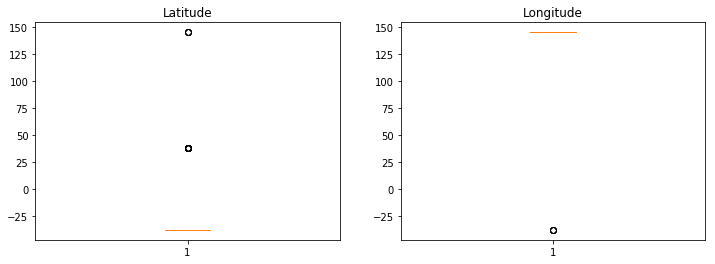

In [36]:
# plotting
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,4))
ax1.boxplot(dirty_data['customer_lat'])
ax1.set_title('Latitude')
ax2.boxplot(dirty_data['customer_lon'])
ax2.set_title('Longitude')
plt.show()

The boxplot is not consistent, we must find out what is wrong. In a first look we observe:
- This variance is not expected, it should be really small. 
- Apparently numbers have been mixed up (lat and lon). They have the same range on the chart, but tey shouldnt.
- There is a strange group of outliers in customer latitude between (25 and 50) that must be understood.
The method `.describe` will useful to continue with our exploration.

In [37]:
pd.DataFrame({'Latitude': dirty_data.customer_lat.describe(), 'Longitude': dirty_data.customer_lon.describe()})

,Latitude,Longitude
count,500.000000,500.000000
mean,-30.753968,143.504504
std,25.336497,16.299324
min,-37.833683,-37.824486
25%,-37.818165,144.951571
50%,-37.812004,144.965090
75%,-37.804329,144.980290
max,144.983125,145.020271


This table corroborates with our theory that numbers have been mixed, as we can see that although both columns have very similar max and minimum numbers, they're distributions are completely different.<br>
Now lets extract all outliers in both columns and find the final proof. I have in the following [post](https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame) (StackOverFlow, 2017) a way to create a function that removes outliers from a dataframe.

In [38]:
def extract_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr 
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return df_out

We will use it in our `dirty_data` to  create a dataframe called `lat_long_outliers` with only the "outliers" regading the `latitude` and `longitude` columns.

In [39]:
lat_long_outliers = [extract_outlier(dirty_data, 'customer_lat'),extract_outlier(dirty_data, 'customer_lon')]
lat_long_outliers = pd.concat(lat_long_outliers)
# checking output (a random sample that shows the 2 different types of problems)
lat_long_outliers.sample(5, random_state = 100)

,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
order_id,,,,,,,,,,,
ORDY05106,2018-10-05,17:07:36,Dinner,TP,"[('Fish&Chips', 1), ('Shrimp', 8), ('Salmon', ...",728.0,37.808036,144.957577,0,9.065,12.882619
ORDK02537,2018-06-25,13:44:47,Lunch,BK,"[('Salad', 6), ('Chicken', 5), ('Burger', 6)]",449.2,144.983125,-37.824274,0,7.013,12.754196
ORDA10971,2018-12-04,19:09:17,Dinner,BK,"[('Salmon', 4), ('Pasta', 2), ('Shrimp', 3)]",381.0,144.969403,-37.824486,0,8.139,15.129492
ORDI10727,2018-08-03,15:05:54,Lunch,NS,"[('Chicken', 2), ('Burger', 5), ('Fries', 10)]",339.0,37.812174,144.973941,0,7.623,13.160695
ORDI09145,2018-03-21,10:32:06,Breakfast,NS,"[('Eggs', 5), ('Cereal', 9), ('Coffee', 8), ('...",407.5,37.814050,144.960195,0,8.186,13.233508


In this dataframe, we have identified clearly:
- In fact latitude and longitude are switched in some cases.
- Many numbers in latitude have their sign switched, that means they are positive but should be negative, which explains the pattern we observed before. <br>

Stablished what needs to be corrected, we will start making changes, by:
- Switching rows in all cases where latitude > longitude, since the boxplot proved only in outliers the opposite happens.   
- Multiplying by -1 all positive latitudes, which is the remaining factor that must be adressed.

In [40]:
customer_lat = list(dirty_data['customer_lat'])
customer_lon = list(dirty_data['customer_lon'])

for i in range(len(customer_lon)):
    if customer_lon[i] < customer_lat[i]:
        customer_lon[i], customer_lat[i] = customer_lat[i], customer_lon[i]
    elif customer_lat[i] > 0:
        customer_lat[i] = customer_lat[i]*-1 

dirty_data['customer_lat'] = customer_lat
dirty_data['customer_lon'] = customer_lon

Let's check again the boxplots after the correction:

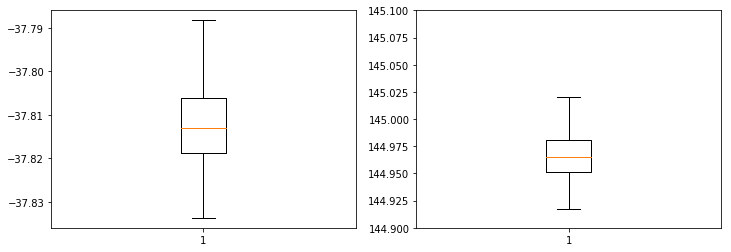

In [41]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,4))
ax1.boxplot(dirty_data['customer_lat'])
ax2.boxplot(dirty_data['customer_lon'])
ax2.set_ylim((144.9,145.1))
plt.show()

Much better! Outliers removed and all values are now within the range of Melboune latitudes/longitudes. We can now proceed to find distance.

### Lets explore the column Distance
We will calculate the real distance in the table outliers using the library [networkx](https://networkx.github.io/documentation/stable/) (NetworkX Developers, 2019a). And we will make use of the following tables:
- outlier_data
- edge_data
- branches_data
- nodes_data

As we know the table outliers has no dirty data, we will test on it if our method to calculate distance is correct, and when positive we will apply to make corrections on the dirty data table.


As our first step here, we will create a graph with the help of [networkx](https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html) (NetworkX Developers, 2019b). It is essential to have [graph data](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) (Wikimedia Foundation, 2019) for this kind of problem.


In [42]:
G=nx.Graph()
print("Graph:", type(G))

Graph: <class 'networkx.classes.graph.Graph'>


Populating the graph with nodes and edges

In [43]:
# adding nodes and edges
G.add_nodes_from(list(nodes_data['node']))

for edge in edge_data.index:
    G.add_edge(edge_data.loc[edge,"u"],edge_data.loc[edge,"v"], weight = edge_data.loc[edge,"distance(m)"])
# let's check the output
print("first five nodes:", list(G.nodes())[0:5], "\n","first five edges:", list(G.edges())[0:5]) 

first five nodes: [711327755, 711327756, 711327759, 711327760, 777781264] 
 first five edges: [(711327755, 711332946), (711327755, 55725841), (711327755, 711327760), (711327756, 703557073), (711327756, 711332946)]


Next steps:
- Connect nodes with latitude and longitude
- Add nodes of branch and destiny to the main table
- Calculate the distance using the *dijkstra algorithm*  through the function `dijkstra_path_length`
- Compare the distance from the function with the table.  

In [44]:
# create dictonary with key = (lat and lon) and value = node
dict_node = nodes_data.set_index(['lat','lon'])['node'].to_dict()

# create list of tuples containing latitude and longitude of each node for customers and branches
customer_coordinates = list(zip(outlier_data['customer_lat'], outlier_data['customer_lon'])) 
branch_coordinates = list(zip(branches_data['branch_lat'], branches_data['branch_lon']))

# adding column of nodes in the dataframes
outlier_data['delivery_nodes'] = [dict_node[coor] for coor in customer_coordinates]
branches_data['nodes'] = [dict_node[coor] for coor in branch_coordinates]

Adding the column of *branch_nodes* in the outlier data according to *the branch_code*

In [45]:
dict_branch_node = branches_data.set_index('branch_code')['nodes'].to_dict()
outlier_data['branch_nodes'] = [dict_branch_node[coor] for coor in outlier_data.branch_code]
# checking the new columns added
outlier_data.head(3) 

,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,delivery_nodes,branch_nodes
order_id,,,,,,,,,,,,,
ORDB09494,2018-03-20,10:32:06,Breakfast,TP,"[('Cereal', 8), ('Pancake', 7), ('Coffee', 8)]",397.75,-37.810429,144.957103,0,8.864,11.374260,6167489414,1390575046
ORDX05338,2018-01-04,08:00:00,Breakfast,BK,"[('Eggs', 2), ('Cereal', 2), ('Pancake', 5)]",207.25,-37.802047,144.984127,1,6.268,5.008869,2170946980,1889485053
ORDX00038,2018-11-10,18:18:35,Dinner,BK,"[('Salmon', 8), ('Fish&Chips', 1), ('Shrimp', 1)]",417.00,-37.819670,145.010019,0,4.324,13.468264,1458418088,1889485053


In [46]:
# calculating the distance
outlier_data['distance'] = outlier_data.apply(lambda row: nx.dijkstra_path_length(
    G, row.delivery_nodes, row.branch_nodes), axis=1)
# Checking the output
print('Same lists:', list(outlier_data['distance']/1000) == list(round(outlier_data['distance_to_customer_KM'],3)))

Same lists: True


The algorithm is working, so lets apply the exact same steps in `dirty_data`:

In [47]:
dirty_customer_coordinates = list(zip(dirty_data['customer_lat'], dirty_data['customer_lon']))
# adding the nodes columns to the dirty data
dirty_data['delivery_nodes'] = [dict_node[coor] for coor in dirty_customer_coordinates]
dirty_data['branch_nodes'] = [dict_branch_node[coor] for coor in dirty_data.branch_code]
# create a new column for distance
dirty_data['distance'] = dirty_data.apply(lambda row: nx.dijkstra_path_length(
    G, row.delivery_nodes, row.branch_nodes)/1000, axis=1)

Now, we will find the number of differences between the old and new distance:

In [48]:
new_distance = list(dirty_data['distance'])
old_distance = list(dirty_data['distance_to_customer_KM'])

different_numbers = []
for i in range(len(new_distance)):
    if round(new_distance[i],3) != round(old_distance[i],3):
        different_numbers.append((new_distance[i],old_distance[i]))

print('Number of different numbers:', len(different_numbers))
print('Examples', different_numbers[0:10])

Number of different numbers: 36
Examples [(7.795, 8.596), (5.105, 7.147), (7.494, 9.942), (9.057, 9.515), (8.966, 10.83), (9.169, 9.947000000000001), (6.216, 5.099), (8.176, 12.785), (7.883, 10.425), (9.942, 9.066)]


Finally, replace the old distance by the newly calculated.

In [49]:
# replacing for the new 
dirty_data['distance_to_customer_KM'] = dirty_data['distance']
# dropping the new columns added only to support the analysis (distance, delivery_nodes, branch_nodes)
dirty_data.drop(columns =['distance', 'delivery_nodes', 'branch_nodes'], inplace=True)
dirty_data.head()

,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
order_id,,,,,,,,,,,
ORDJ10441,2018-06-22,13:34:38,Lunch,TP,"[('Fries', 8), ('Burger', 1), ('Salad', 3), ('...",242.60,-37.804428,145.001706,0,11.725,14.528886
ORDJ07328,2018-05-07,12:13:31,Lunch,TP,"[('Salad', 4), ('Chicken', 7)]",292.80,-37.803965,144.957401,0,9.326,12.480629
ORDK05266,2018-06-19,13:34:38,Lunch,BK,"[('Chicken', 3), ('Fries', 7)]",180.00,-37.821107,145.001579,0,5.099,10.859659
ORDY06038,2018-05-01,11:53:14,Breakfast,TP,"[('Cereal', 2), ('Eggs', 8), ('Coffee', 5)]",255.50,-37.803248,145.001800,0,11.773,14.206698
ORDA06375,2018-03-17,10:21:58,Breakfast,BK,"[('Pancake', 3), ('Coffee', 8), ('Cereal', 4),...",370.75,-37.807633,144.942262,0,9.536,17.477364


## 3.9. customerHasloyalty?
We know that delivery fee is calculated using a different method for each branch.

The fee depends linearly (but in different ways for each branch) on:

<b>a.</b> weekend or weekday (1 or 0) - as a continuous variable

<b>b.</b> time of the day (morning 0, afternoon 1, evening 2) - as a continuous variable

<b>c.</b> distance between branch and customer

<b>If a customer has loyalty, they get a 50% discount on delivery fee</b>

We know that there are no dirty data neither in the `delivery_fee` nor in the `time` and we have already fixed the `distance`, `branch_code` and `date`. That way, we can retrieve all dependent and independent variables of the delirery fee regressions. What still might be wrong here is the customer loyalty. To check it, we will retrieve the regression coefficients using the missing data file values. 

Why the missing data? We know all datasets come from the same distribution, but we cannot use the dirty data because we don't know were the wrong entries are and we should not use the outliers because they will bias the regression. 


In [50]:
regression_data = missing_data.loc[:,['date','order_type','branch_code','customerHasloyalty?',
                                      'delivery_fee', 'distance_to_customer_KM']]
regression_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, ORDI05516 to ORDA08079
Data columns (total 6 columns):
date                       500 non-null object
order_type                 500 non-null object
branch_code                400 non-null object
customerHasloyalty?        500 non-null int64
delivery_fee               450 non-null float64
distance_to_customer_KM    450 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 19.5+ KB


We need complete rows of the information contained in `regression_data` to perform this task. As we can see above, 50 out of the 500 rows in out dataframe has missing values of delivery_fee and 100 are missing for branch_code. We are going to drop these rows and proceed with the analysis:

1 - Create `weekend_or_weekday` variable;

2 - Create `time_of_day` variable;

3 - Multiply the `delivery_fee` by 2 in case the customer has loyalty;

4 - Divide the data in the 3 different  branches in order to execute 3 diferent regressions.

In [51]:
# removing missing data
regression_data = regression_data.dropna()
regression_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, ORDI05516 to ORDA08079
Data columns (total 6 columns):
date                       350 non-null object
order_type                 350 non-null object
branch_code                350 non-null object
customerHasloyalty?        350 non-null int64
delivery_fee               350 non-null float64
distance_to_customer_KM    350 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 13.7+ KB


To obtain the new columns for the regression, we will need to make maniupulations with the columns that we have in `regression_data`, like converting to strings to date and making classifications according to day of week. We will make use of `lambda functions` + `apply` method, as teached in this [post](https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7) (Agarwal, 2019).

1 - Create weekend_or_weekday variable <br>
In `datetime` pandas, weekdays are numbered from 0 to 4, and weekeend as 5 and 6. We will use this information to make our classification.  

In [52]:
# convert date to datetime and add column for weekday
regression_data.loc[:,'date'] = pd.to_datetime(regression_data.loc[:,'date'], format = '%Y-%m-%d')
regression_data.loc[:,'day_of_week'] = regression_data.loc[:,'date'].dt.weekday

# classify in weekday_or_weekend
test_weekday = lambda x : 1 if (x > 4) else 0
regression_data.loc[:,'weekend_or_weekday'] = regression_data.loc[:,'day_of_week'].apply(test_weekday)

2 -  Create time_of_day variable<br>
We know that breakfast is served on the morning and so on and so forth. This will be our trigger for classification.

In [53]:
# classify in time_of_day
test_hour = lambda x : 0 if (x == 'Breakfast') else (1 if x == 'Lunch' else 2)
regression_data.loc[:,'time_of_day'] = regression_data.loc[:,'order_type'].apply(test_hour)

3 -  Multiply delivery_fee of loyal custumers<br>
Every customer that is loyal (customerHasloyalty? == 1) will have its price multiplied by two (to find the original price, without discount).  

In [54]:
# Find price from loyaltity
modified_loyalty = regression_data[regression_data['customerHasloyalty?'] == 1]['delivery_fee'].apply(lambda x: x*2)
regression_data.loc[modified_loyalty.index, 'delivery_fee'] = modified_loyalty

4 - Create a separated dataframe for each branch <br>
Each branch has a different regression, so, in order to fit them, we divide our `regression_data` into `regression_ns`, `regression_bk` and `regression_tp`. These dataframes only need the information about the `delivery_fee`, `distance`,`time_of_day` and `weekend_or_weekday` to help us find out the regression parameters.

In [55]:
reg_vars = ['delivery_fee','time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM']
regression_ns = regression_data[regression_data['branch_code']=='NS'][reg_vars]
regression_bk = regression_data[regression_data['branch_code']=='BK'][reg_vars]
regression_tp = regression_data[regression_data['branch_code']=='TP'][reg_vars]

<b> Calculating delivery_fee linear regression </b><br>
We now have all the data we need to retrieve the coefficients from our linear equations of delivery fee. We use the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) (sklearn Project, 2019) linear regression to fit a regression to our data points and make the predictions ahead.

In [56]:
lm_delivery = [LinearRegression()]*3 #instantiate
i = 0
for reg in [regression_ns, regression_bk, regression_tp]:
    X = reg[[x for x in reg.columns if x != 'delivery_fee']]
    Y = reg['delivery_fee']
    reg  = lm_delivery[i].fit(X, Y) #fit
    # print R squared
    print("R2 : ", reg.score(X,Y)) 
    i +=1

R2 :  0.9722733846670395
R2 :  0.9790661806314702
R2 :  0.939977433030309


As we can see in the R squared above, we have excelent fits for all branches. We are going to use the models to find out if the delivery fee we have in our data is consistent with the predicted value of the linear regression. If it is not, it means that our `customerHasloyalty?` variable is wrong.

First, we will need to follow the same steps as before (convert `date` to find weekday, create `weekday_or_weekend` and `time_of_day` columns):

In [57]:
regression_data = dirty_data.loc[:,['date','order_type','branch_code','customerHasloyalty?',
                                      'delivery_fee', 'distance_to_customer_KM']]

# convert date to datetime and add column for weekday
regression_data.loc[:,'date'] = pd.to_datetime(regression_data.loc[:,'date'], format = '%Y-%m-%d')
regression_data.loc[:,'day_of_week'] = regression_data.loc[:,'date'].dt.weekday

# classify in weekday_or_weekend
test_weekday = lambda x : 1 if (x > 4) else 0
regression_data.loc[:,'weekend_or_weekday'] = regression_data.loc[:,'day_of_week'].apply(test_weekday)

# classify in time_of_day
test_hour = lambda x : 0 if (x == 'Breakfast') else (1 if x == 'Lunch' else 2)
regression_data.loc[:,'time_of_day'] = regression_data.loc[:,'order_type'].apply(test_hour)

We also create one dataframe per branch to make the predictions:

In [58]:
# separating the dataframes by branch
reg_vars = ['delivery_fee', 'time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM','customerHasloyalty?']
regression_ns = regression_data[regression_data['branch_code']=='NS'][reg_vars]
regression_bk = regression_data[regression_data['branch_code']=='BK'][reg_vars]
regression_tp = regression_data[regression_data['branch_code']=='TP'][reg_vars]

Then, we apply the regressions fitted above and compare their result with the given `delivery_fee`.

In [59]:
# fitting the values:
i = 0
for reg in [regression_ns, regression_bk, regression_tp]:
    X = reg[[x for x in reg.columns if x not in ['delivery_fee','customerHasloyalty?']]]
    Y = reg['delivery_fee']
    reg['predict']  = lm_delivery[i].predict(X) #fit
    reg['predict_loyalty'] = reg['predict']/2
    i +=1

As we have an R-squared > 93% for all branches, we can expect that if the `delivery_fee` is more distant from the `predict` than it is from `predict`/2, it means the customer has discount.

In [60]:
for reg in [regression_ns, regression_bk, regression_tp]:
    reg['loyalty'] = 0
    loyalty_condition = abs(reg['predict_loyalty']-reg['delivery_fee']) < abs(reg['predict']-reg['delivery_fee'])
    reg.loc[loyalty_condition, 'loyalty'] = 1
    # how many mismatches?
    print("Wrong Loyalty: ",sum(reg['customerHasloyalty?'] != reg['loyalty']))                                   

Wrong Loyalty:  10
Wrong Loyalty:  13
Wrong Loyalty:  14


So, we can see that for the branches NS, BK and TP the there are 10, 13 and 14 data errors for the `customerHasloyalty?` variables, respectively. Now, we will replace them by the correct values:

In [61]:
dirty_data.loc[regression_ns.index, 'customerHasloyalty?'] = regression_ns.loyalty
dirty_data.loc[regression_bk.index, 'customerHasloyalty?'] = regression_bk.loyalty
dirty_data.loc[regression_tp.index, 'customerHasloyalty?'] = regression_tp.loyalty

Now that we finished our analysis and have fixed the errors in the dirty data file, we save it as `Group103_dirty_data_solution.csv`.

In [62]:
dirty_data.to_csv('Group103_dirty_data_solution.csv')

# 4. Outliers

Detect and remove outlier rows in `Group103_outlier_data.csv` (outliers are to be found w.r.t. `delivery_fee` attribute).

## 4.1. Analysing delivery_fee

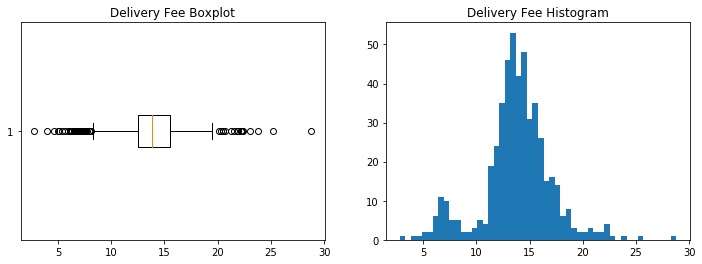

In [63]:
# plotting
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,4))
ax1.boxplot(outlier_data['delivery_fee'], vert =0 )
ax1.set_title('Delivery Fee Boxplot')
ax2.hist(outlier_data['delivery_fee'], bins=50)
ax2.set_title('Delivery Fee Histogram')
plt.show()

We can see a lot of outliers, specially between 6 and 8. However, we can not treat it as a univariate problem, as the delivery fee is a function of other variables that might be consistent with this result. 

## 4.2. Linear Regression Multivariate Residual Analysis

We will adopt a multiple regression residual analysis [approach](https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-multiple-regression/mlr-residual-analysis-and-outliers.html) (Statistics Knowledge Portal, 2019). We know that the delivery fee is calculated using a different method for each branch and depends linearly on: `weekend_or_weekday`, `time_of_day` and `distance_to_customer_KM`. If a customer has loyalty, they get a 50% discount on delivery fee. 

First, we will replicate the steps adopted to find dirty data in `customerHasLoyalty?` to generate the `weekend_or_weekday` and `time_of_day` variables:

In [64]:
regression_data = outlier_data.loc[:,['date','order_type','branch_code','customerHasloyalty?',
                                      'delivery_fee', 'distance_to_customer_KM']]

# convert date to datetime and add column for weekday
regression_data.loc[:,'date'] = pd.to_datetime(regression_data.loc[:,'date'], format = '%Y-%m-%d')
regression_data.loc[:,'day_of_week'] = regression_data.loc[:,'date'].dt.weekday

# classify in weekday_or_weekend
test_weekday = lambda x : 1 if (x > 4) else 0
regression_data.loc[:,'weekend_or_weekday'] = regression_data.loc[:,'day_of_week'].apply(test_weekday)

# classify in time_of_day
test_hour = lambda x : 0 if (x == 'Breakfast') else (1 if x == 'Lunch' else 2)
regression_data.loc[:,'time_of_day'] = regression_data.loc[:,'order_type'].apply(test_hour)

# Find price from loyaltity
modified_loyalty = regression_data[regression_data['customerHasloyalty?'] == 1]['delivery_fee'].apply(lambda x: x*2)
regression_data.loc[modified_loyalty.index, 'delivery_fee'] = modified_loyalty

We also create one dataframe per branch to fit the linear models:

In [65]:
# separating the dataframes by branch
reg_vars = ['delivery_fee', 'time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM','customerHasloyalty?']
regression_ns = regression_data[regression_data['branch_code']=='NS'][reg_vars]
regression_bk = regression_data[regression_data['branch_code']=='BK'][reg_vars]
regression_tp = regression_data[regression_data['branch_code']=='TP'][reg_vars]

<b> Calculating delivery_fee linear regression </b><br>
We now have all the data we need to retrieve the coefficients from our linear equations of delivery fee. We use the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) (sklearn Project, 2019) linear regression to fit a regression to our data points and calculate the residuals as: <br>
$$ residual = delivery_{}fee_{predicted} - delivery_{}fee_{observed}$$

In [66]:
lm_delivery = [LinearRegression()]*3 #instantiate
branches = ["NS", "BK", "TP"]
i = 0
for reg in [regression_ns, regression_bk, regression_tp]:
    X = reg[['time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM']]
    Y = reg['delivery_fee']
    lm_delivery[i]  = lm_delivery[i].fit(X, Y) #fit
    reg['predict']  = lm_delivery[i].predict(X) #predict
    # calculate residuals
    reg['residual'] = reg['delivery_fee'] - reg['predict']
    # print R squared
    print("R2  ", branches[i]," : ",lm_delivery[i].score(X,Y)) 
    i +=1

R2   NS  :  0.3051771885220085
R2   BK  :  0.4216110146120935
R2   TP  :  0.2574454163220312


We can see that the R squared of of branches is really low (less than half of what we found when analysing the missing data). That happens due to the present of outliers. Now, lets analyse the residuals:

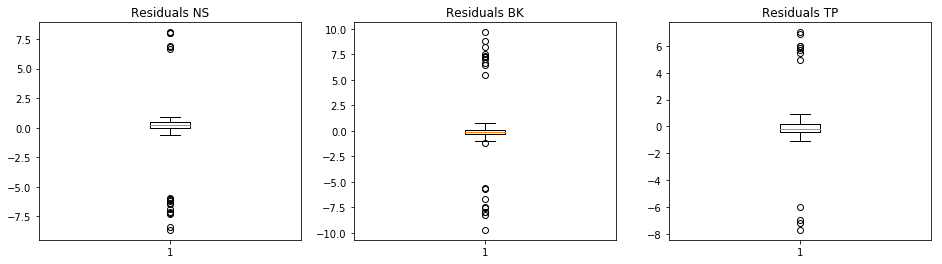

In [67]:
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(16,4))
ax1.boxplot(regression_ns['residual'])
ax1.set_title('Residuals NS')
ax2.boxplot(regression_bk['residual'])
ax2.set_title('Residuals BK')
ax3.boxplot(regression_tp['residual'])
ax3.set_title('Residuals TP')
plt.show()

The outliers are very well delimited for all three branches, as we can observe in the boxplots above. 

## 4.3. Removing the Outliers

Now, lets clean our dataset eliminating them with the previously defined `extract_outlier()` [function](https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame) (StackOverFlow user2708149, 2017) and check how does our regressions look like after this cleaning.

Number of Outliers   NS  :  18
Number of Outliers   BK  :  21
Number of Outliers   TP  :  12


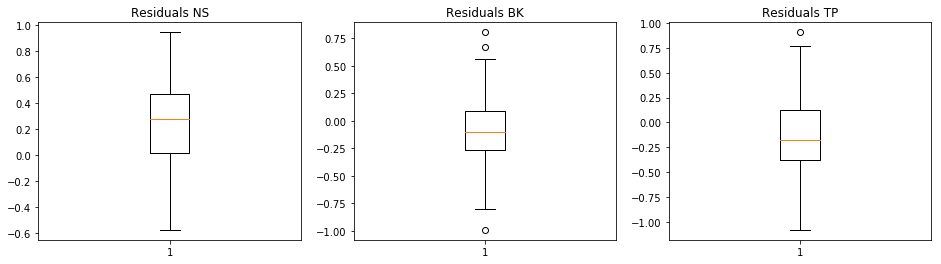

In [68]:
outlier = {} # dictionary with outlier index per branch
branches = ["NS", "BK", "TP"]
i=0
for reg in [regression_ns, regression_bk, regression_tp]:
    outlier[branches[i]] = extract_outlier(reg, 'residual').index
    print("Number of Outliers  ", branches[i]," : ", len(outlier[branches[i]]))
    # removing outliers
    reg.drop(outlier[branches[i]], inplace=True)
    i+=1
    
# checking residuals
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(16,4))
ax1.boxplot(regression_ns['residual'])
ax1.set_title('Residuals NS')
ax2.boxplot(regression_bk['residual'])
ax2.set_title('Residuals BK')
ax3.boxplot(regression_tp['residual'])
ax3.set_title('Residuals TP')
plt.show()

Much better ! Let's check out new R squared of the regressions disregarding the outliers:

In [69]:
lm_delivery = [LinearRegression()]*3 #instantiate
i = 0
branches = ["NS", "BK", "TP"]
for reg in [regression_ns, regression_bk, regression_tp]:
    X = reg[['time_of_day', 'weekend_or_weekday','distance_to_customer_KM']]
    Y = reg['delivery_fee']
    lm_delivery[i]  = lm_delivery[i].fit(X, Y) #fit
    # print R squared
    print("R2  ", branches[i]," : ",lm_delivery[i].score(X,Y)) 
    i +=1

R2   NS  :  0.9641206593560986
R2   BK  :  0.9837588054378266
R2   TP  :  0.9457465670959625


Huge improvement in the R2 coefficient ! Now, it's only left to exclude this outliers from our `outlier_data`, which is easily done by dropping their correspondent indexes:

In [70]:
# all outliers index:
outlier_index = list(outlier['NS']) + list(outlier['BK']) + list(outlier['TP'])
# number of rows before:
print("Number of Rows Originally in Outlier Data : ",len(outlier_data))
# eliminating outliers:
outlier_data.drop(outlier_index, inplace=True)
# number of rows after:
print("Number of Rows After Removing Outliers : ",len(outlier_data))

Number of Rows Originally in Outlier Data :  500
Number of Rows After Removing Outliers :  449


Now that we finished our analysis and have removed the outliers, we save it as `Group103_outlier_data_solution.csv`.

In [71]:
# dropping the new columns added only to support the analysis (distance, delivery_nodes, branch_nodes)
outlier_data.drop(columns =['distance', 'delivery_nodes', 'branch_nodes'], inplace=True)
# saving
outlier_data.to_csv('Group103_outlier_data_solution.csv')

# 5.  Missing Data

Now, we will explore and make imputations in the table `missing_data` that is supposed to have missing values in some columns.
Our first step is to perform explorations using the method `.info()` that will return the number of non-null rows in each column.

In [72]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, ORDI05516 to ORDA08079
Data columns (total 11 columns):
date                       500 non-null object
time                       500 non-null object
order_type                 500 non-null object
branch_code                400 non-null object
order_items                500 non-null object
order_price                500 non-null float64
customer_lat               500 non-null float64
customer_lon               500 non-null float64
customerHasloyalty?        500 non-null int64
distance_to_customer_KM    450 non-null float64
delivery_fee               450 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 35.2+ KB


There are null values in 3 columns: `branch_code`, `distance_to_customer_KM` and `delivery_fee`. This are actually great news!
We will be able to find all missing values without much difficulties. Here is why:
1. The column `branch_code` is fully dependent on the index(`order_id`). We have explored this relation in the point 3.3.1. Therefore, we will make use of the index to find all branch_codes. 
2. The `distance_to_customer_KM` is a function of `branch_code` (through their locations) and `customer_lat` and `customer_lon`. After step 1 we will be able to find it without further problems. 
3. Finally, we have already developed a linear regression to find the `delivery fee`. Once step 1 and 2 are finalized we will calculate `delivery fee`.

## 5.1. branch_code

Lets start by step1. We will make use of the dictionary we have already created `dict_id_branch`. After creating a column that has only the fourth letter of the *order_id* called *new_id* we will replace missing values by the `branch_code` equivalent. <br>
Also, a regex pattern `ORD([A-Z])` will be used to extract the 4th character.

In [73]:
pattern_id = r'ORD([A-Z])'
extract_id = lambda x: re.search(pattern_id, x).group(1)
missing_data['new_id'] = missing_data.index.map(extract_id)
missing_data['branch_code'] = missing_data['new_id'].replace(dict_id_branch)

## 5.2. distance_to_customer_KM

Now we will work on step2. We already have elaborated a graph with all nodes, so it will be a simple application of previous works. We will make use of the following objects:<br>
- `G:` The graph that contains all nodes and edges in the city.
- `dict_node:` A dictionary with latitude and longitude as key and node as items (all items in the graph).
- `dict_branch_node:` A dictionary with branch_code as key and node as items.

We will calculate all distances as before and replace then on the dataframe, eliminating all null values. 


In [74]:
missing_customer_coordinates = list(zip(missing_data['customer_lat'], missing_data['customer_lon']))
missing_data['delivery_nodes'] = [dict_node[coor] for coor in missing_customer_coordinates]
missing_data['branch_nodes'] = [dict_branch_node[coor] for coor in missing_data.branch_code]
missing_data['distance_to_customer_KM'] = missing_data.apply(
    lambda row: nx.dijkstra_path_length(G, row.delivery_nodes, row.branch_nodes)/1000, axis=1)

## 5.3. delivery_fee
Finally, we are in step 3. Even thought we have already worked on the `delivery_fee` column in both dirty data and outlier files, we will use all these information together with the missing data (non-missing rows) here. We fit the same regression model here of:
$$delivery_{fee} = \alpha + \beta_1*distance_{}to_{}customer_{}KM+\beta_2*time_{}of_{}day+\beta_3*weekend_{}or_{}weekday$$
Even though it is not necessary, we'll recalibrate the model using all the data we have (now we have already imputed some data, deleted outliers and fixed error and can estimate our parameters with a more complete dataset). FInally, we use it to impute the missing values here. 

In [75]:
# getting all available data and relevant columns to work on the regression
regression_data = missing_data.loc[:,['date','order_type','branch_code','customerHasloyalty?',
                                      'delivery_fee', 'distance_to_customer_KM']].append(
    outlier_data.loc[:,['date','order_type','branch_code','customerHasloyalty?',
                                      'delivery_fee', 'distance_to_customer_KM']]).append(
    dirty_data.loc[:,['date','order_type','branch_code','customerHasloyalty?',
                                      'delivery_fee', 'distance_to_customer_KM']])

We need to generate the `weekend_or_weekday` and `time_of_day` columns and treat the loyalty issue the same way as we did before.

In [76]:
# convert date to datetime and add column for weekday
regression_data.loc[:,'date'] = pd.to_datetime(regression_data.loc[:,'date'], format = '%Y-%m-%d')
regression_data.loc[:,'day_of_week'] = regression_data.loc[:,'date'].dt.weekday

# classify in weekday_or_weekend
test_weekday = lambda x : 1 if (x > 4) else 0
regression_data.loc[:,'weekend_or_weekday'] = regression_data.loc[:,'day_of_week'].apply(test_weekday)

# classify in time_of_day
test_hour = lambda x : 0 if (x == 'Breakfast') else (1 if x == 'Lunch' else 2)
regression_data.loc[:,'time_of_day'] = regression_data.loc[:,'order_type'].apply(test_hour)

# Find price from loyaltity
modified_loyalty = regression_data[regression_data['customerHasloyalty?'] == 1]['delivery_fee'].apply(lambda x: x*2)
regression_data.loc[modified_loyalty.index, 'delivery_fee'] = modified_loyalty

We also create one dataframe per branch to fit the linear models:

In [77]:
# separating the dataframes by branch
reg_vars = ['delivery_fee', 'time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM','customerHasloyalty?']
regression_ns = regression_data[regression_data['branch_code']=='NS'][reg_vars].dropna()
regression_bk = regression_data[regression_data['branch_code']=='BK'][reg_vars].dropna()
regression_tp = regression_data[regression_data['branch_code']=='TP'][reg_vars].dropna()

<b> Calculating delivery_fee linear regression </b><br>
We now have all the data we need to retrieve the coefficients from our linear equations of delivery fee. We use the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) (sklearn Project, 2019) linear regression to fit a regression to our data points and make the predictions ahead.

In [78]:
lm_delivery = [LinearRegression()]*3 #instantiate
i = 0
branches = ["NS", "BK", "TP"]
for reg in [regression_ns, regression_bk, regression_tp]:
    X = reg[['time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM']]
    Y = reg['delivery_fee']
    reg  = lm_delivery[i].fit(X, Y) #fit
    # print R squared
    print("R2  ", branches[i]," : ",lm_delivery[i].score(X,Y)) 
    i +=1

R2   NS  :  0.9667658237106492
R2   BK  :  0.9799893722104978
R2   TP  :  0.9434524886034308


Excelent fits ! (All R squared > 94%).

Now, we apply the regressions fitted above to the missing data rows:

In [79]:
reg_cols = ['delivery_fee', 'time_of_day', 'weekend_or_weekday', 'distance_to_customer_KM','customerHasloyalty?']
na_data = regression_data[regression_data.isnull().any(axis=1)]
# how many missing data?
len(na_data)
# divide by branch
regression_ns = na_data[na_data['branch_code']=='NS'][reg_cols]
regression_bk = na_data[na_data['branch_code']=='BK'][reg_cols]
regression_tp = na_data[na_data['branch_code']=='TP'][reg_cols]

Predict the missing values of `delivery_fee`:

In [80]:
# fitting the values:
i = 0
for reg in [regression_ns, regression_bk, regression_tp]:
    X = reg[[x for x in reg.columns if x not in ['delivery_fee','customerHasloyalty?']]]
    reg['delivery_fee']  = lm_delivery[i].predict(X) #fit
    # taking into acount loyalty discount
    reg.loc[reg['customerHasloyalty?'] == 1,'delivery_fee'] = reg.loc[reg['customerHasloyalty?'] == 1,'delivery_fee']/2
    i +=1

And finally, make the imputations:

In [81]:
# imputing the predicted values
missing_data.loc[regression_ns.index,'delivery_fee'] = regression_ns['delivery_fee']
missing_data.loc[regression_bk.index,'delivery_fee'] = regression_bk['delivery_fee']
missing_data.loc[regression_tp.index,'delivery_fee'] = regression_tp['delivery_fee']

Now that we finished our analysis and have imputed all missing values in the missing data file, we save it as `Group103_missing_data_solution.csv`.

In [82]:
# dropping the new columns added only to support the analysis (distance, delivery_nodes, branch_nodes)
missing_data.drop(columns =['new_id', 'delivery_nodes', 'branch_nodes'], inplace=True)
# saving
missing_data.to_csv('Group103_missing_data_solution.csv')

# 6. Summary
This assessment measured the understanding of data cleasing techniques in the Python programming language. The main outcomes achieved while applying these techniques were:

- **Data Exploration**. Finding dirty data can be quite challenging when not much clues are given. Some of the tools that we used to explore the data were:
    - `re library:` A valuable resource to deal with strings and identify patterns. It was specially helpful to find out the patern in `order_id` and make it possible to relate the 4th letter with `branch_code`.
    - `Boxplots:` When trying to understand a numerical distribution and spot outliers, it was a very useful tool.
    - `Descriptive and Exploration Functions:` *pd.crosstab*, *.info()* and *.value_counts()* were a few of the functions that were extensively used to give insights or confirm that a correct measure was taken.
- **Graphs and Shortest Path**. By using the library `Networkx`, a graph representing the region that comprises the restaunts and the orders was generated. Graphs are composed by *nodes*, *edges* and *wheights(distances)*. With the functions `dijkstra_path_length()`, it was possible to access the optimized path between each branch and the delivery adress.
- **Data Imputation**. Using the descriptive function `.info()` the missing values were imidiately quantified. Hopefully, we found a straitgh path to replace missing values using *regressions (from delivery fee)*, *direct replacement (branch_code)* and the *dijkstra algorithm (distance)*
- **Linear Regression**. Fitting linear models with `sklearn.linear_model.LinearRegression` and making an multivariate residuals analysis for outliers. 
- **Outlier Extraction**. Identifying outliers can be a very challenging task, but as we knew which methodology to follow we only needed to analyse the outliers with the linear model for the residuals. A function called *extract_outlier* was used in this assignment to remove the residuals outliers based on the 1.5*IQR rule .
- **Working with Dates**. Pandas has the function `datetime` that can be used for conversion of datatypes into dates. However when working in many different formats it is not possible to use it. Each format mas be treated individually.
- **Linear Algebra**. We have used `numpy.linalg` to solve a system of linear equations when retriving the menus. It was a challenging and very useful part of this assignment. 


# References

- Agarwal, Rahul (2019, July 02). *Apply and Lambda usage in pandas*. Retrieved from
https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7


- EdChum (2016, April 25). *how to replace an entire column on Pandas.DataFrame* [Response to]. Retrieved from 
https://stackoverflow.com/questions/36846060/how-to-replace-an-entire-column-on-pandas-dataframe

- Jan Goyvaerts - regular-expressions.info. (2019). *Grouping and Capturing*. Retrieved from <br>https://www.regular-expressions.info/brackets.html


- LatitudeLongitude.org (2015). *Melbourne, Australia latitude longitude*. Retrieved from <br>https://latitudelongitude.org/au/melbourne/


- NetworkX Developers. (2019a). *Creating a graph* .
Retrieved from <br> https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html

- NetworkX Developers. (2019b). *Overview of NetworkX* .
Retrieved from <br> https://networkx.github.io/documentation/stable/


- pandas 0.25.1 documentation. (2019). `pandas.Series.value_counts`. Retrieved from <br> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html

- Python Software Foundation. (2019). `re` *— Regular expression operations*. Retrieved from <br>https://docs.python.org/3/library/re.html

- Statistics Knowledge Portal (2019). *Multiple Regression Residual Analysis and Outliers*. Retrieved from
https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-multiple-regression/mlr-residual-analysis-and-outliers.html

- The `pandas` Project. (2019). *pandas 0.25.1 documentation: pandas.DataFrame.to_csv*. Retrieved from
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html#pandas.Series.apply


- The `scipy` Project. (2019). *numpy 1.17 documentation: numpy.linalg.solve*. Retrieved from
https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve


- The `sklearn` Project. (2019). *sklearn 0.21.3 documentation: sklearn.linear_model.LinearRegression*. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict

- Tiwari, Abhishek (2019). *Creating a Pandas Series*. Retrieved from https://www.geeksforgeeks.org/creating-a-pandas-series/

- user2708149. (2017, October 14). *Detect and exclude outliers in Pandas data frame?* [Response to]. Retrieved from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame


- Varshney, Raju (2019). *Permutation and Combination in Python*. Retrieved from https://www.geeksforgeeks.org/permutation-and-combination-in-python/


- Wikimedia Foundation, Inc. (2019). *Graph (discrete mathematics)* .
Retrieved from <br> https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)